# Experimental
Notebook to generate table1, fig1, fig2 and associated supplementary results

## Reqs

In order to run this notebook you have to download / get following file in addition to the files already present in the repository :
- `hg38/cytoBand-human-GRCh38-hg38.txt` # Follow instruction from `hg38/get_files.md` section `CYTOBAND FILE`
- `data/experimental/experimental.tsv` # Obtained from Zenodo

In [1]:
GENERATE_RESULTS = (
    True  # if set to true it will generate results in outputs/ directory.
)


from pathlib import Path
from collections import defaultdict
from random import randint

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Rectangle, Polygon

from utils import utils


# Matplotlib configuration
fontdict = {"size": 10, "family": "sans-serif"}
mpl.rc("font", **fontdict)
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
PROJECT_DIR = Path().absolute().parent

## Notebook's specific functions


In [2]:
def valid_selection(mask_columns=None, select_columns=None):
    if mask_columns and select_columns:
        raise ValueError("Cannot specify both mask_columns and select_columns.")
    if not mask_columns and not select_columns:
        raise ValueError("Must specify either mask_columns or select_columns.")
    if mask_columns is not None:
        selection = pl.exclude(mask_columns)
    elif select_columns is not None:
        selection = [select_columns]
    return selection


# Correlation Functions
def compute_spearman(df, mask_columns=None, select_columns=None):
    """Compute Spearman correlation for a dataframe excluding masked columns."""
    selection = valid_selection(mask_columns, select_columns)
    ranked_df = df.select(
        [pl.col(col).rank().alias(col) for col in df.select(selection).columns]
    )
    return ranked_df.corr()


def compute_pearson(df, mask_columns=None, select_columns=None):
    """Compute Pearson correlation for a dataframe excluding masked columns."""
    selection = valid_selection(mask_columns, select_columns)
    return df.select(selection).corr()


def get_corr_df(df, mask_columns=None, method="spearman"):
    """
    Extract relevant correlations from a correlation matrix.

    Args:
        df: Input dataframe
        mask_columns: Columns to exclude from correlation analysis
        method: Correlation method ('spearman' or 'pearson')

    Returns:
        DataFrame with selected correlation pairs
    """
    correlations = defaultdict(list)

    if method == "spearman":
        corr_df = compute_spearman(df, mask_columns)
    elif method == "pearson":
        corr_df = compute_pearson(df, mask_columns)
    else:
        raise ValueError(f"Method should be 'spearman' or 'pearson', got '{method}'")

    # Extract correlations involving RADD or AP
    for i, row_name in enumerate(corr_df.columns):
        for j, col_name in enumerate(corr_df.columns):
            if i >= j:  # Skip symmetric pairs
                continue
            if row_name in ["RADD", "AP"] or col_name in ["RADD", "AP"]:
                correlations[f"{row_name} vs {col_name}"].append(corr_df[i, j])

    return pl.DataFrame(correlations)


# Data Aggregation
def aggregate(data, agg_size, columns=None):
    """
    Aggregate genomic data by binning positions.

    Args:
        data: Input dataframe with 'chr', 'start', 'end' columns
        agg_size: Size of bins for aggregation
        columns: Columns to aggregate (default: all except chr, start, end)

    Returns:
        Aggregated dataframe
    """
    columns = columns or data.select(pl.exclude("start", "end", "chr")).columns

    return (
        data.group_by(["chr", pl.col("start") // agg_size])
        .agg(
            pl.col(columns).mean(),
            pl.col("start").min().alias("true_start"),
            pl.col("end").max(),
        )
        .drop("start")
        .rename({"true_start": "start"})
        .sort(pl.col("start"))
    )


# Scaling Functions
def robust_scale(s: pl.Series) -> pl.Series:
    """Scale series using robust scaling (IQR-based)."""
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    median = s.median()
    iqr = q3 - q1
    return (s - median) / iqr


def winsorized_scale(s: pl.Series, lower=0.05, upper=0.95) -> pl.Series:
    """Scale series using winsorized scaling (clip outliers then robust scale)."""
    q_low = s.quantile(lower)
    q_high = s.quantile(upper)
    s_clipped = s.clip(q_low, q_high)

    q1 = s_clipped.quantile(0.25)
    q3 = s_clipped.quantile(0.75)
    median = s_clipped.median()
    iqr = q3 - q1

    return (s_clipped - median) / iqr


def rank_normalize(s: pl.Series) -> pl.Series:
    """Normalize series by rank transformation."""
    return s.rank() / s.len()


def z_scale(s: pl.Series) -> pl.Series:
    """Standard z-score normalization."""
    return (s - s.mean()) / s.std()

### Plot

In [3]:
# Plotting Configuration
CYTOBAND_DF = pl.read_csv(
    PROJECT_DIR / "hg38" / "cytoBand-human-GRCh38-hg38.txt", separator="\t"
)

GIE_COLORS = {
    "gneg": "white",
    "gpos25": "#C8C8C8",
    "gpos50": "#A0A0A0",
    "gpos75": "#707070",
    "gpos100": "black",
    "gvar": "#DCDCDC",
    "stalk": "#A0A0F0",
    "acen": "#B40000",
}

GIE_TEXTURE = {"gvar": "/"}

COLUMN_LABEL_MAP = {
    "7.4": r"$\overline{W}$",
    "vipper": r"$-\overline{vIP}$",
    "RADD": r"$RADD$",
    "AP": r"$AP$",
}

LABEL_COLORS = {"vipper": 4, "RADD": 9, "AP": 0}


def _draw_cytoband(ax_band, chr_name, y_center=0, height=0.4):
    """Draw chromosome ideogram on axis."""
    chr_cytoband_df = CYTOBAND_DF.filter(pl.col("chrom") == chr_name)

    # Draw bands
    for row in chr_cytoband_df.iter_rows(named=True):
        x0, x1 = row["chromStart"], row["chromEnd"]
        stain = row["gieStain"]
        color = GIE_COLORS.get(stain, "white")

        rect = Rectangle(
            (x0, y_center - height / 2),
            x1 - x0,
            height,
            facecolor=color,
            edgecolor="black",
            # hatch=GIE_TEXTURE(stain, None),
            linewidth=0.5,
        )
        ax_band.add_patch(rect)

    # Draw centromere
    acen = chr_cytoband_df.filter(pl.col("gieStain") == "acen").to_dicts()
    if len(acen) == 2:
        left, right = acen

        # Left centromere polygon
        ax_band.add_patch(
            Polygon(
                [
                    (left["chromStart"], y_center - height / 2),
                    (left["chromEnd"], y_center),
                    (left["chromStart"], y_center + height / 2),
                ],
                closed=True,
                color=GIE_COLORS["acen"],
            )
        )

        # Right centromere polygon
        ax_band.add_patch(
            Polygon(
                [
                    (right["chromEnd"], y_center - height / 2),
                    (right["chromStart"], y_center),
                    (right["chromEnd"], y_center + height / 2),
                ],
                closed=True,
                color=GIE_COLORS["acen"],
            )
        )

    ax_band.set_ylim(-0.6, 0.6)
    ax_band.axis("off")


def _plot_chromosome_signal(
    ax_signal, chr_data, visible_columns, gap_threshold, plot_legend=True
):
    """Plot chromosome signal data with gap handling."""
    for col in visible_columns:
        x = chr_data["start"].to_numpy()
        y = chr_data[f"{col}_normed"].to_numpy()

        # Find gaps and split into segments
        gaps = np.where(np.diff(x) > gap_threshold)[0]
        segments = np.split(np.arange(len(x)), gaps + 1)

        color = mpl.cm.tab20c(LABEL_COLORS.get(col, randint(0, 20)))

        label_ploted = False
        for idx, seg in enumerate(segments):
            if (
                max(x[seg]) - min(x[seg]) < (max(x) - min(x)) * 0.1
            ):  # Si moins de 10% de la taille du chrom
                continue

            label = None if label_ploted else COLUMN_LABEL_MAP.get(col, col)
            ax_signal.plot(x[seg], y[seg], color=color, label=label)
            label_ploted = True


def _format_axis_labels(ax_signal):
    """Format axis labels with scientific notation."""
    ax_signal.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

    offset_text = ax_signal.xaxis.get_offset_text().get_text()
    ax_signal.xaxis.get_offset_text().set_visible(False)

    if offset_text and "e" in offset_text:
        base, exp = offset_text.split("e")
        exp = exp.lstrip("+")
        label = rf"Genomic Position ($\times 10^{{{exp}}}$)"
    else:
        label = "Genomic Position"

    ax_signal.set_xlabel(label)
    ax_signal.set_ylabel("Normalized Value")


def _format_legend(ax_signal):
    """Format legend appearance."""
    legend = ax_signal.legend(
        frameon=True, framealpha=1, edgecolor="black", fontsize=10, loc="upper right"
    )
    legend.get_frame().set_linewidth(0.5)


def plot_chr(
    chr_data,
    visible_columns=None,
    agg_size=100_000,
    chr_col_label="chr",
    gaussian_filter=False,
    ax_pair=None,
    gap_threshold=500_000,
    norm_function=z_scale,
    plot_legend=True
):
    """
    Plot chromosome ideogram with signal data.

    Args:
        chr_data: Chromosome data (must contain only one chromosome)
        visible_columns: Columns to visualize
        agg_size: Bin size for aggregation
        chr_col_label: Name of chromosome column
        gaussian_filter: Whether to apply Gaussian smoothing
        ax_pair: Optional tuple (ax_band, ax_signal) for existing axes
        gap_threshold: Threshold for detecting gaps in data
        norm_function: Function for normalizing values

    Returns:
        Figure object if standalone mode, None otherwise
    """
    # Aggregate and validate data
    chr_data = aggregate(chr_data, agg_size=agg_size)
    visible_columns = visible_columns or ["RADD", "AP", "vipper"]

    chr_name = chr_data[chr_col_label].unique()
    if len(chr_name) != 1:
        raise ValueError("chr_data contains more or less than 1 chromosome")
    chr_name = chr_name[0]

    # Create or use existing axes
    standalone = ax_pair is None
    if standalone:
        fig, (ax_band, ax_signal) = plt.subplots(
            2, 1, figsize=(8, 3), gridspec_kw={"height_ratios": [1, 3]}, sharex=True
        )
    else:
        ax_band, ax_signal = ax_pair

    ax_band.grid(False)
    ax_signal.grid(False)
    ax_band.set_facecolor("white")
    ax_signal.set_facecolor("white")
    # Normalize data
    chr_data_normalized = chr_data.with_columns(
        [norm_function(pl.col(col)).alias(f"{col}_normed") for col in visible_columns]
    )

    # Apply Gaussian filter if requested
    if gaussian_filter:
        chr_data_normalized = chr_data_normalized.with_columns(
            [
                pl.Series(
                    f"{col}_normed",
                    gaussian_filter1d(chr_data_normalized[f"{col}_normed"], sigma=10),
                )
                for col in visible_columns
            ]
        )

    # Plot components
    _plot_chromosome_signal(
        ax_signal, chr_data_normalized, visible_columns, gap_threshold, plot_legend
    )
    _draw_cytoband(ax_band, chr_name)

    # Add chromosome label
    xmin, xmax = 0, chr_data["end"].max()
    ax_band.text(
        xmin - (xmax - xmin) * 0.03,
        0,
        chr_name,
        va="center",
        ha="right",
        fontsize=10,
        fontweight="bold",
    )

    _format_axis_labels(ax_signal)

    # Configure spines after all drawing (including cytoband axis("off"))
    for spine in ["left", "bottom"]:
        ax_signal.spines[spine].set_visible(True)
        ax_signal.spines[spine].set_color("black")
    for spine in ["top", "right"]:
        ax_signal.spines[spine].set_visible(False)

    if standalone:
        _format_legend(ax_signal)
        plt.tight_layout(h_pad=0)
        return fig

## Generate_plot

In [4]:
datas = pl.read_csv(
    PROJECT_DIR / "data" / "experimental" / "experimental.tsv", separator="\t"
).with_columns(
    (
        (pl.col("C") + pl.col("G"))
        / (pl.col("C") + pl.col("G") + pl.col("A") + pl.col("T"))
    ).alias("GC"),
    -pl.col("vipper").alias("vipper"),
)
datas

chr,start,end,RADD,AP,vipper,7.2,7.3,7.4,7.5,7.6,7.7,7.8,A,T,C,G,GC
str,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
"""chr1""",792600,792800,208.89,0.119255,-6.351157,1,4,11,17,38,66,108,47,84,38,31,0.345
"""chr1""",792800,793000,8.4125,0.11168,-6.552395,1,5,20,31,60,81,129,44,59,73,24,0.485
"""chr1""",793000,793200,118.635,0.064813,-6.29344,1,4,10,20,48,75,116,57,61,39,43,0.41
"""chr1""",793200,793400,36.6425,0.075229,-6.480196,1,8,18,26,52,79,111,49,68,53,30,0.415
"""chr1""",793400,793600,1.995,0.164578,-6.340972,1,4,13,20,43,62,94,38,98,42,22,0.32
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chrY""",26636400,26636600,0.5,0.02311,-6.222073,0,4,15,20,39,69,106,66,59,40,35,0.375
"""chrY""",26636600,26636800,0.5,0.005267,-6.231944,1,2,10,19,52,78,106,65,56,33,46,0.395
"""chrY""",26636800,26637000,0.5,0.00685,-6.090612,2,13,25,34,66,97,136,47,52,48,53,0.505


/tmp/ipykernel_4072231/903574260.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax_band, ax_signal) = plt.subplots(


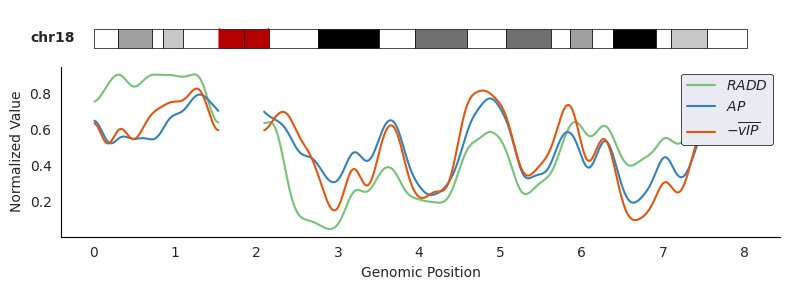

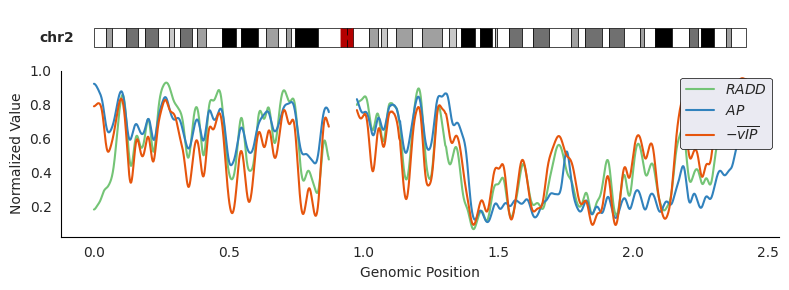

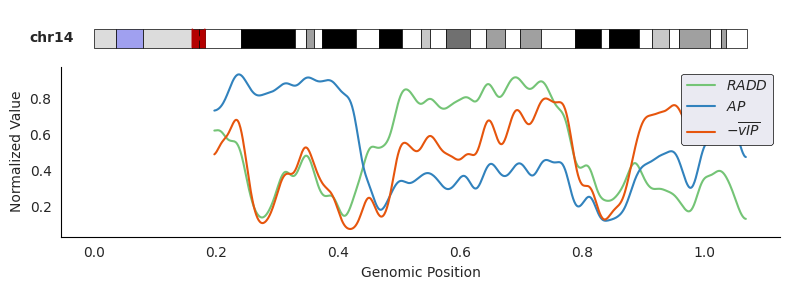

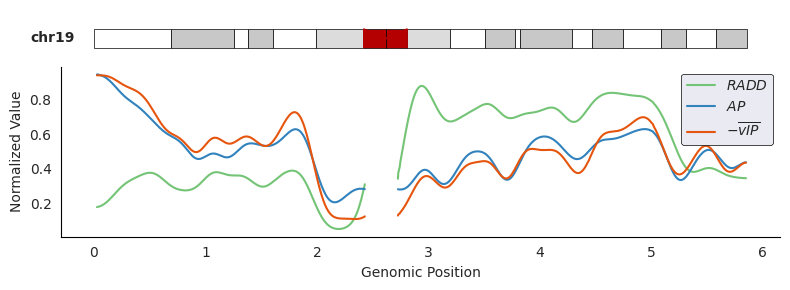

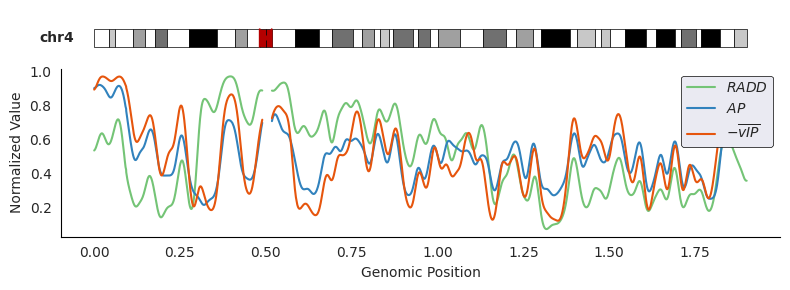

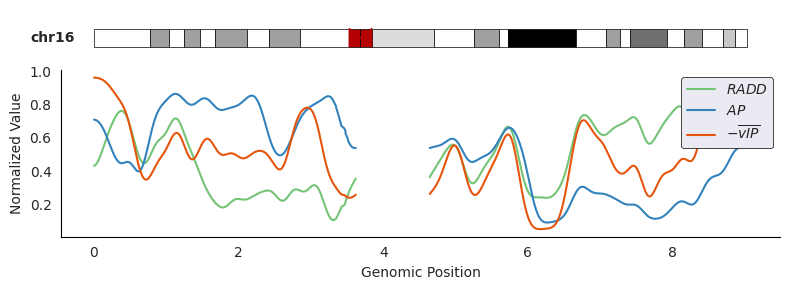

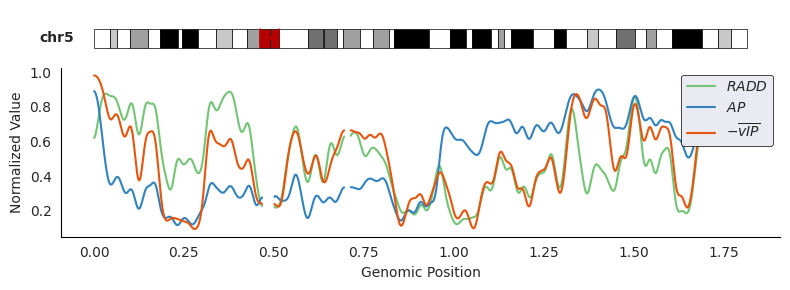

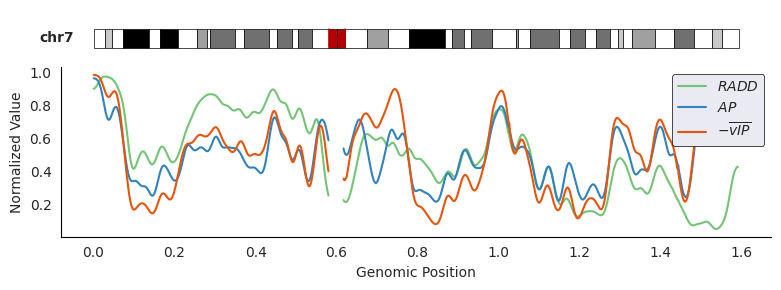

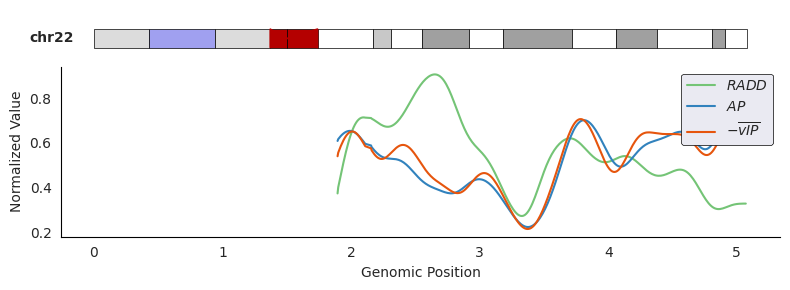

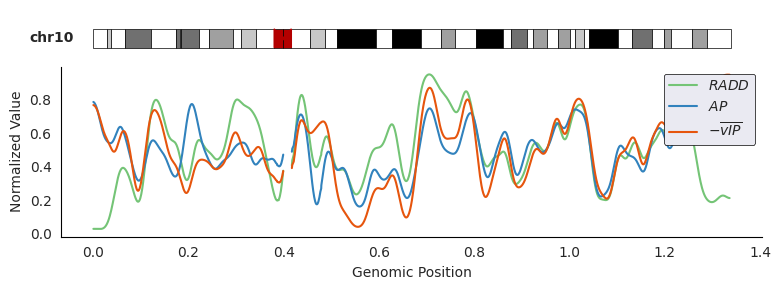

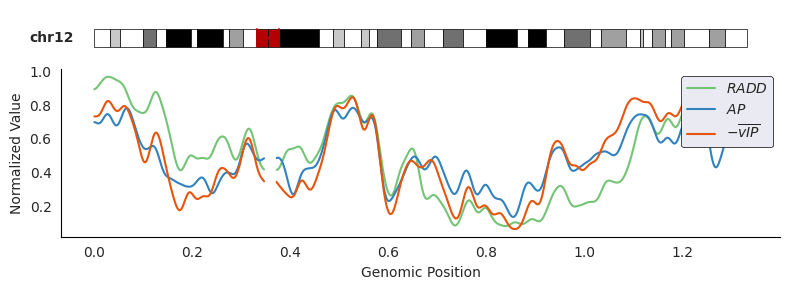

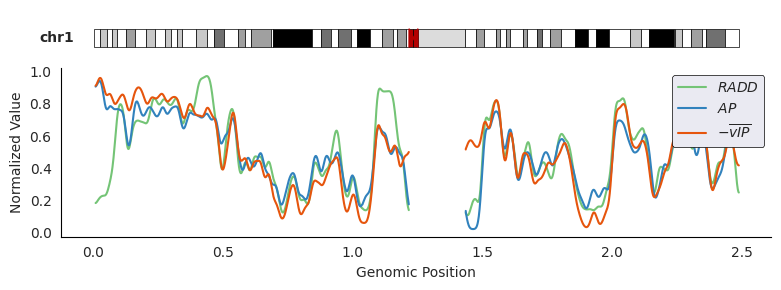

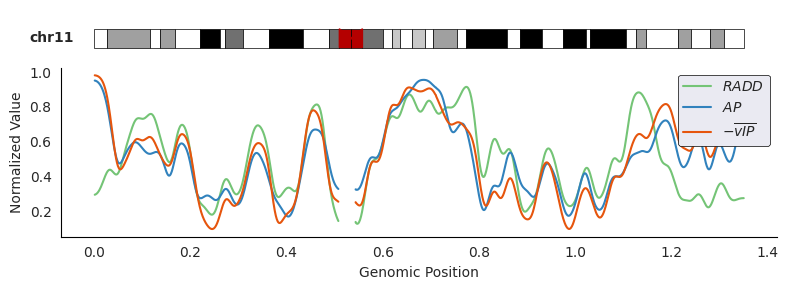

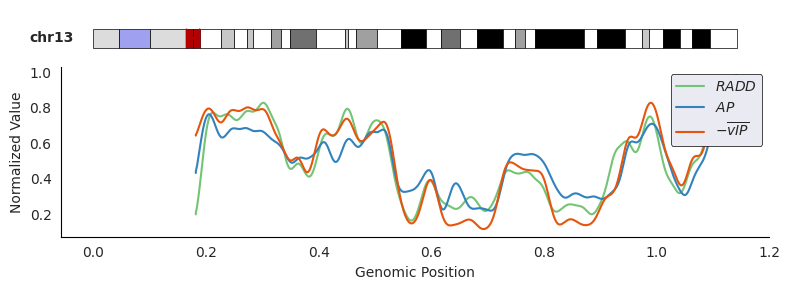

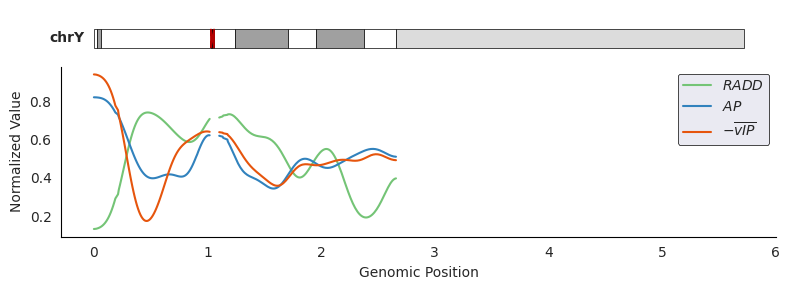

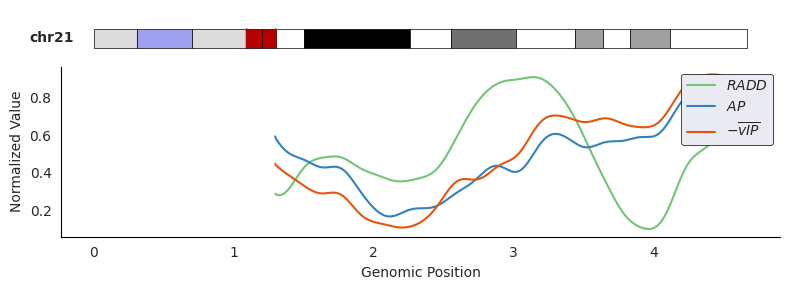

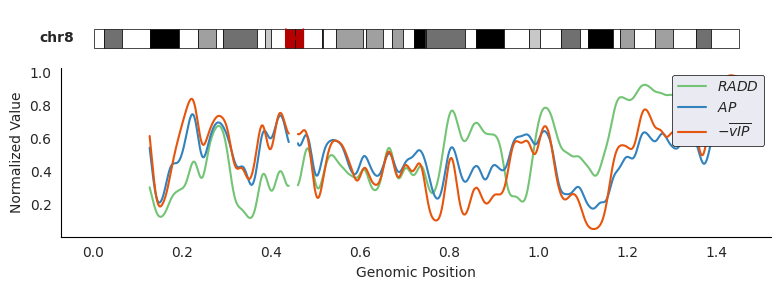

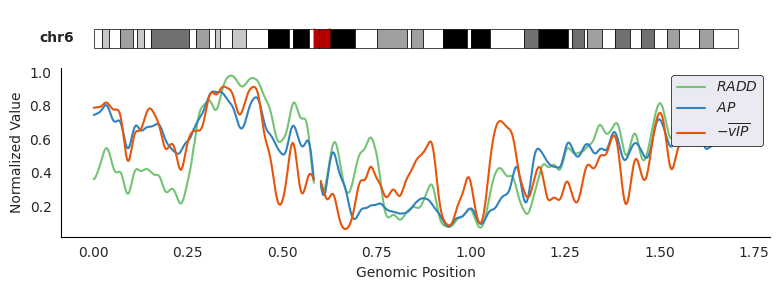

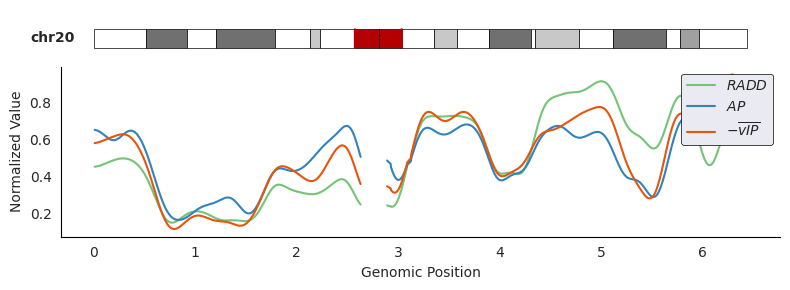

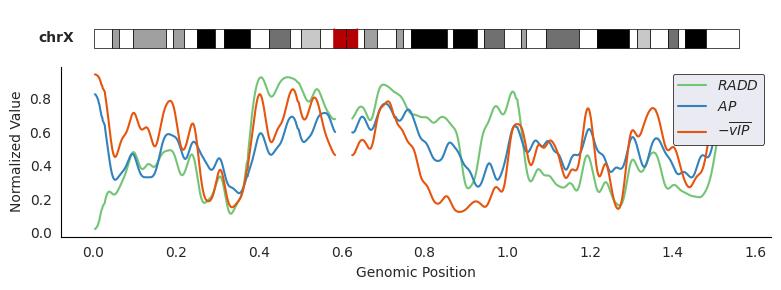

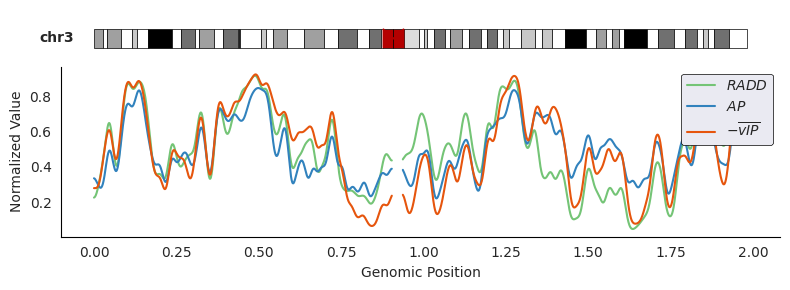

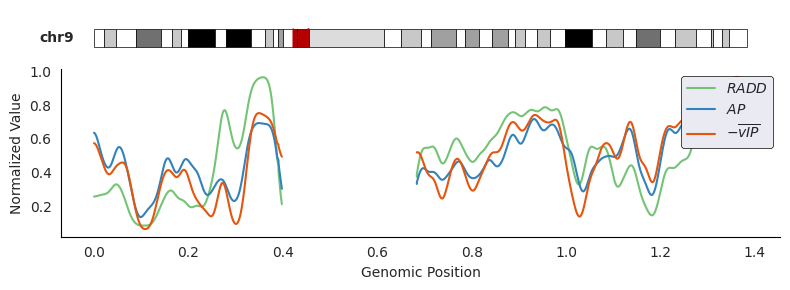

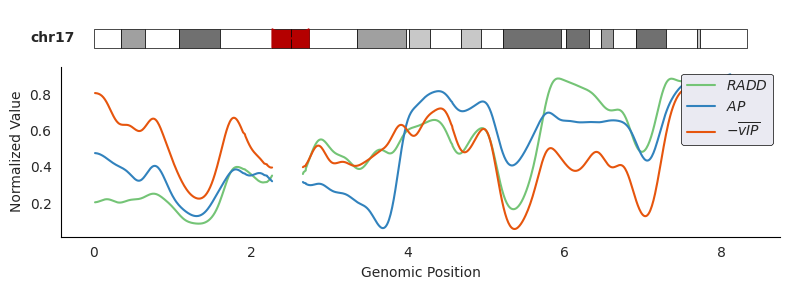

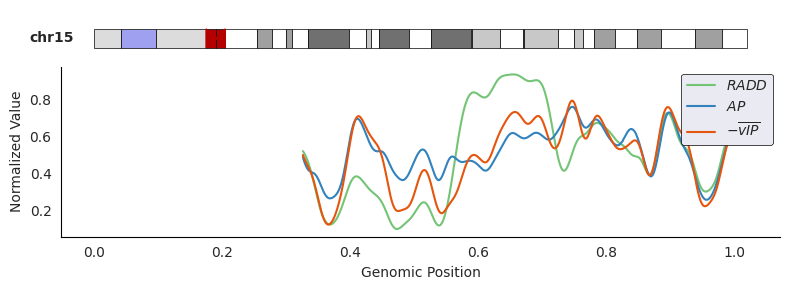

In [5]:
plot_legend = True

for chr in datas["chr"].unique():
    fig = plot_chr(
        datas.filter(pl.col("chr") == chr).drop_nulls(),
        agg_size=100_000,
        gaussian_filter=True,
        norm_function=rank_normalize,
        visible_columns=["RADD", "AP", "vipper"],
        plot_legend=plot_legend
    )
    plot_legend = False
    if GENERATE_RESULTS:
        output_path = PROJECT_DIR / "outputs" / "experimental" / "chr" / f"{chr}.svg"
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path)

## Correlation values (no wells)

In [6]:
# Correlation Analysis: Effect of Aggregation Size
AGG_SIZES = (
    [200, 1000, 5000, 10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]
    if GENERATE_RESULTS
    else [200, 20000, 100_000]
)  # for speed
METHOD = "spearman"

columns = ["RADD", "vipper", "AP", "GC"]
correlations_evolution = pl.DataFrame()

for agg_size in AGG_SIZES:
    # Aggregate data
    tmp_df = aggregate(datas.drop_nulls(), agg_size=agg_size, columns=columns)

    # Compute correlations
    corr_df = get_corr_df(
        tmp_df, mask_columns=["chr", "start", "end"], method=METHOD
    ).with_columns(
        pl.lit(agg_size).alias("agg_size"),
    )

    correlations_evolution = pl.concat(
        [correlations_evolution, corr_df],
        how="diagonal",
    )

utils.print_markdown(
    correlations_evolution["agg_size", "RADD vs vipper", "vipper vs AP", "RADD vs AP"]
)
if GENERATE_RESULTS:
    output_path = PROJECT_DIR / "outputs" / "experimental" / f"evolution_of_corr_{METHOD}.tsv"
    output_path.parent.mkdir(exist_ok=True, parents=True)
    correlations_evolution["agg_size", "RADD vs vipper", "vipper vs AP", "RADD vs AP"].write_csv(output_path, separator="\t")

|   agg_size |   RADD vs vipper |   vipper vs AP |   RADD vs AP |
|------------|------------------|----------------|--------------|
|        200 |             0.13 |           0.15 |         0.2  |
|       1000 |             0.26 |           0.27 |         0.29 |
|       5000 |             0.42 |           0.43 |         0.39 |
|      10000 |             0.48 |           0.47 |         0.42 |
|      20000 |             0.53 |           0.5  |         0.45 |
|      50000 |             0.56 |           0.52 |         0.47 |
|     100000 |             0.58 |           0.53 |         0.48 |
|     200000 |             0.59 |           0.55 |         0.5  |
|     500000 |             0.6  |           0.58 |         0.52 |
|    1000000 |             0.6  |           0.6  |         0.53 |


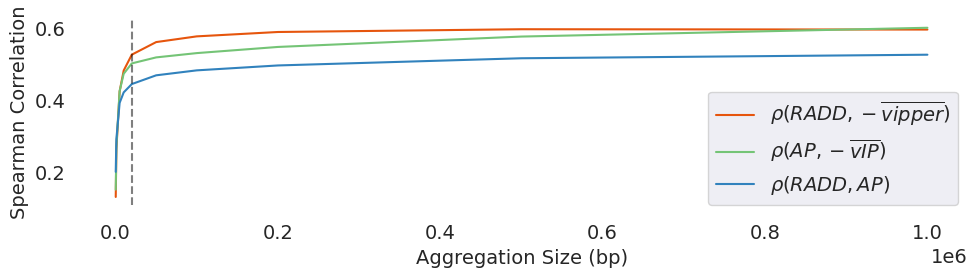

In [7]:
# Plot correlation evolution for selected metrics
mpl.rc("font", size=14, family="sans-serif")

PLOT_COLS = ["RADD vs vipper", "vipper vs AP", "RADD vs AP"]
PLOT_LABELS = {
    "RADD vs vipper": r"$\rho(RADD,-\overline{vipper})$",
    "AP vs vipper": r"$\rho(AP,-\overline{vIP})$",
    "vipper vs AP": r"$\rho(AP,-\overline{vIP})$",
    "RADD vs AP": r"$\rho(RADD,AP)$",
}
PLOT_COLORS = {
    "RADD vs vipper": 4,
    "AP vs vipper": 9,
    "vipper vs AP": 9,
    "RADD vs AP": 0,
}
# Create main plot
fig, ax = plt.subplots(figsize=(10, 3))

for col in ["RADD vs vipper", "vipper vs AP", "RADD vs AP"]:
    if col == "agg_size":
        continue
    sub_df = correlations_evolution.select([col, "agg_size"])
    ax.plot(
        sub_df["agg_size"],
        sub_df[col],
        label=PLOT_LABELS.get(col, col),
        color=mpl.cm.tab20c(PLOT_COLORS.get(col, randint(0, 20))),
    )

# Add vertical line at optimal aggregation size
y_min, y_max = ax.get_ylim()
ax.grid(False)
ax.set_facecolor("white")
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.vlines(20_000, y_min, y_max, color="k", linestyles="--", alpha=0.5)

ax.set_ylabel("Spearman Correlation")
ax.set_xlabel("Aggregation Size (bp)")
ax.legend()
plt.tight_layout()
if GENERATE_RESULTS:
    output_path = PROJECT_DIR / "outputs" / "experimental" / "supplementary" / f"evolution_of_corr_{METHOD}.svg"
    output_path.parent.mkdir(exist_ok=True, parents=True)
    plt.savefig(output_path, bbox_inches="tight")
plt.show()

In [8]:
# Partial Correlation Analysis: Controlling for GC Content

# Compute partial correlations for different aggregation sizes
partial_correlations_evolution = pl.DataFrame()

for agg_size in AGG_SIZES:
    # Aggregate data
    tmp_df = aggregate(datas.drop_nulls(), agg_size=agg_size, columns=columns)

    # Compute partial correlations controlling for GC
    partial_vip_radd, p_vip_radd = utils.partial_correlation(
        tmp_df, "vipper", "RADD", "GC", stat_method=stats.spearmanr
    )
    partial_vip_ap, p_vip_ap = utils.partial_correlation(
        tmp_df, "vipper", "AP", "GC", stat_method=stats.spearmanr
    )
    partial_radd_ap, p_radd_ap = utils.partial_correlation(
        tmp_df, "RADD", "AP", "GC", stat_method=stats.spearmanr
    )

    # Store results
    row = pl.DataFrame(
        {
            "vipper vs RADD (partial)": [p_vip_radd],
            "vipper vs AP (partial)": [p_vip_ap],
            "RADD vs AP (partial)": [p_radd_ap],
            "agg_size": [agg_size],
        }
    )

    partial_correlations_evolution = pl.concat(
        [partial_correlations_evolution, row], how="diagonal"
    )

print("Partial Pearson Correlations (controlling for GC content):")
utils.print_markdown(
    partial_correlations_evolution,
)

Partial Pearson Correlations (controlling for GC content):
|   vipper vs RADD (partial) |   vipper vs AP (partial) |   RADD vs AP (partial) |   agg_size |
|----------------------------|--------------------------|------------------------|------------|
|                          0 |                        0 |                      0 |        200 |
|                          0 |                        0 |                      0 |       1000 |
|                          0 |                        0 |                      0 |       5000 |
|                          0 |                        0 |                      0 |      10000 |
|                          0 |                        0 |                      0 |      20000 |
|                          0 |                        0 |                      0 |      50000 |
|                          0 |                        0 |                      0 |     100000 |
|                          0 |                        0 |                    

## Correlation values (wells)

### Specific function

In [16]:
def plot_scatterplot(
    df,
    x="well vs radd",
    y="well vs ap",
    hue="metric",
    size="agg_size",
    x_label=r"$p(\mathrm{well}, r_{\mathrm{add}})$",
    y_label=r"$p(\mathrm{well}, \mathrm{ap})$",
    hue_label="wells threshold",
    output_name=None,
    transparent_background=False,
):
    """Create scatterplot with customizable columns and labels."""
    fig, ax = plt.subplots()
    sns.scatterplot(
        data=df, x=x, y=y, hue=hue, size=size, sizes=(20, 200), alpha=0.7, ax=ax
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc="upper left")
    legend.set_title(hue_label)

    if output_name is not None and GENERATE_RESULTS:
        output_path = PROJECT_DIR / "outputs" / output_name
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            output_path, bbox_inches="tight", transparent=transparent_background
        )
        print(f"Figure saved to {output_path}")

    plt.show()
    return ax


def plot_heatmaps(
    df,
    index="agg_size",
    columns="metric",
    value1="well vs radd",
    value2="well vs ap",
    title1=r"$p(\mathrm{well}, r_{\mathrm{add}})$",
    title2=r"$p(\mathrm{well}, \mathrm{ap})$",
    x_label="wells threshold",
    y_label="agg_size",
    output_name=None,
    transparent_background=False,
):
    """Create two heatmaps with customizable columns and labels."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    df_pandas = df.to_pandas()
    heatmap1 = df_pandas.pivot(index=index, columns=columns, values=value1)
    heatmap2 = df_pandas.pivot(index=index, columns=columns, values=value2)

    sns.heatmap(
        heatmap1,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        ax=ax1,
        cbar_kws={"label": "Value"},
        vmin=0,
        vmax=1,
    )
    ax1.set_title(title1)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)

    sns.heatmap(
        heatmap2,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        ax=ax2,
        cbar_kws={"label": "Value"},
        vmin=0,
        vmax=1,
    )
    ax2.set_title(title2)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)

    plt.tight_layout()

    if output_name is not None and GENERATE_RESULTS:
        output_path = PROJECT_DIR / "outputs" / output_name
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            output_path, bbox_inches="tight", transparent=transparent_background
        )
        print(f"Figure saved to {output_path}")

    plt.show()
    return fig, (ax1, ax2)


def plot_lineplots(
    df,
    x="metric",
    y1="well vs radd",
    y2="well vs ap",
    hue="agg_size",
    x_label="wells threshold",
    y1_label=r"$p(\mathrm{well}, r_{\mathrm{add}})$",
    y2_label=r"$p(\mathrm{well}, \mathrm{ap})$",
    title1=r"$p(\mathrm{well}, r_{\mathrm{add}})$ vs wells threshold",
    title2=r"$p(\mathrm{well}, \mathrm{ap})$ vs wells threshold",
    hue_label="agg_size",
    log_scale=True,
    output_name=None,
    transparent_background=False,
):
    """Create line plots with customizable columns and labels."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    df_pandas = df.to_pandas()

    sns.lineplot(data=df_pandas, x=x, y=y1, hue=hue, marker="o", ax=ax1)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label)
    ax1.set_title(title1)
    ax1.legend(title=hue_label)

    sns.lineplot(data=df_pandas, x=x, y=y2, hue=hue, marker="o", ax=ax2)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y2_label)
    ax2.set_title(title2)
    ax2.legend(title=hue_label)
    if log_scale:
        ax1.set_xscale("log")
        ax2.set_xscale("log")

    plt.tight_layout()

    if output_name is not None and GENERATE_RESULTS:
        output_path = PROJECT_DIR / "outputs" / output_name
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            output_path, bbox_inches="tight", transparent=transparent_background
        )
        print(f"Figure saved to {output_path}")

    plt.show()
    return fig, (ax1, ax2)


def aggregate_wells(data, agg_size, columns=None):
    """Aggregate wells data: sum for wells-count columns, mean for everything else."""
    WELLS_COLS = {"7.2", "7.4", "7.6", "7.8", "8.0", "8.2"}
    columns = columns or data.select(pl.exclude("start", "end", "chr")).columns

    wells_cols = [c for c in columns if c in WELLS_COLS]
    mean_cols = [c for c in columns if c not in WELLS_COLS]

    agg_exprs = []
    if mean_cols:
        agg_exprs.append(pl.col(mean_cols).mean())
    if wells_cols:
        agg_exprs.append(pl.col(wells_cols).sum())

    return (
        data.group_by(["chr", pl.col("start") // agg_size])
        .agg(
            *agg_exprs,
            pl.col("start").min().alias("true_start"),
            pl.col("end").max(),
        )
        .drop("start")
        .rename({"true_start": "start"})
        .sort(pl.col("start"))
    )

In [23]:
AGG_SIZES_WELLS = (
     [x for x in range(200,10200,200)] +  [x for x in range(10000,110_000,10000)] + [x for x in range(100_000, 1_100_000, 100_000)]
    if GENERATE_RESULTS
    else [200, 20000, 100_000]
)  # for speed

METRICS_WELLS = [
    "vipper",
    "7.2",
    "7.4",
    "7.6",
    "7.8",
]  # wells-density thresholds

correlations_wells = {
    "metric": [],
    "agg_size": [],
    "well vs radd": [],
    "well vs ap": [],
    "GC vs ap": [],
    "GC vs radd": [],
    "well vs GC": [],
}

for agg_size in AGG_SIZES_WELLS:
    data_aggregated = aggregate_wells(datas.drop_nulls(), agg_size=agg_size)
    radd = data_aggregated["RADD"].to_numpy()
    ap = data_aggregated["AP"].to_numpy()
    gc = data_aggregated["GC"].to_numpy()
    corr_GC_radd, _ = stats.spearmanr(gc, radd)
    corr_GC_ap, _ = stats.spearmanr(gc, ap)

    for metric in METRICS_WELLS:
        try:
            well = data_aggregated[metric].to_numpy()
            corr_well_radd, _ = stats.spearmanr(well, radd)
            corr_well_ap, _ = stats.spearmanr(well, ap)
            corr_well_gc, _ = stats.spearmanr(well, gc)

            correlations_wells["metric"].append(metric)
            correlations_wells["agg_size"].append(agg_size)
            correlations_wells["well vs radd"].append(corr_well_radd)
            correlations_wells["well vs ap"].append(corr_well_ap)
            correlations_wells["GC vs ap"].append(corr_GC_ap)
            correlations_wells["GC vs radd"].append(corr_GC_radd)
            correlations_wells["well vs GC"].append(corr_well_gc)
        except Exception as e:
            print(f"Error for metric {metric}, agg_size {agg_size}: {e}")

correlations_evolution_wells = pl.DataFrame(correlations_wells, strict=False)
correlations_evolution_wells

metric,agg_size,well vs radd,well vs ap,GC vs ap,GC vs radd,well vs GC
str,i64,f64,f64,f64,f64,f64
"""vipper""",200,0.130518,0.151026,0.237132,0.234809,0.60802
"""7.2""",200,0.102136,0.166596,0.237132,0.234809,0.545341
"""7.4""",200,0.213504,0.22697,0.237132,0.234809,0.886758
"""7.6""",200,0.219262,0.235253,0.237132,0.234809,0.951612
"""7.8""",200,0.220122,0.222961,0.237132,0.234809,0.956863
…,…,…,…,…,…,…
"""vipper""",1000000,0.597344,0.602365,0.600865,0.595156,0.998065
"""7.2""",1000000,0.527441,0.560616,0.600865,0.595156,0.904678
"""7.4""",1000000,0.463205,0.532663,0.600865,0.595156,0.891659


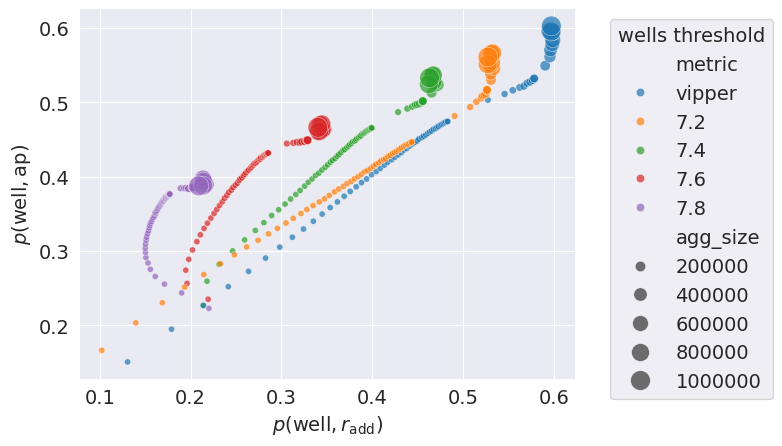

<Axes: xlabel='$p(\\mathrm{well}, r_{\\mathrm{add}})$', ylabel='$p(\\mathrm{well}, \\mathrm{ap})$'>

In [24]:
plot_scatterplot(
    correlations_evolution_wells,
    x="well vs radd",
    y="well vs ap",
)

Figure saved to /home/ben/projects/vIP/paper/outputs/experimental/supplementary/correlations_evolution_wells_scatter.svg


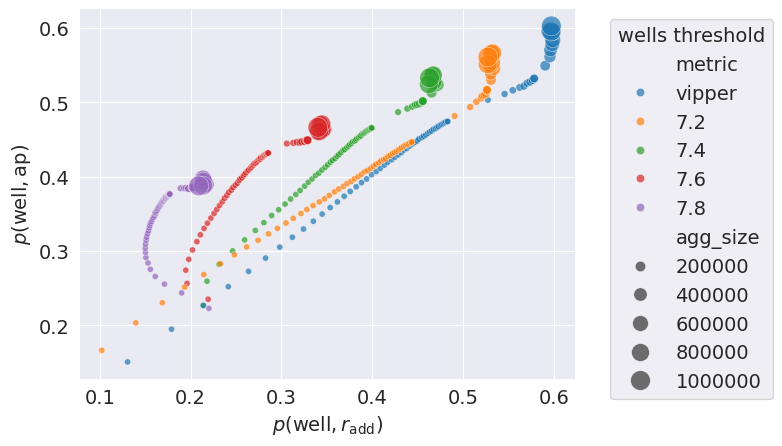

Figure saved to /home/ben/projects/vIP/paper/outputs/experimental/supplementary/correlations_evolution_wells_line.svg


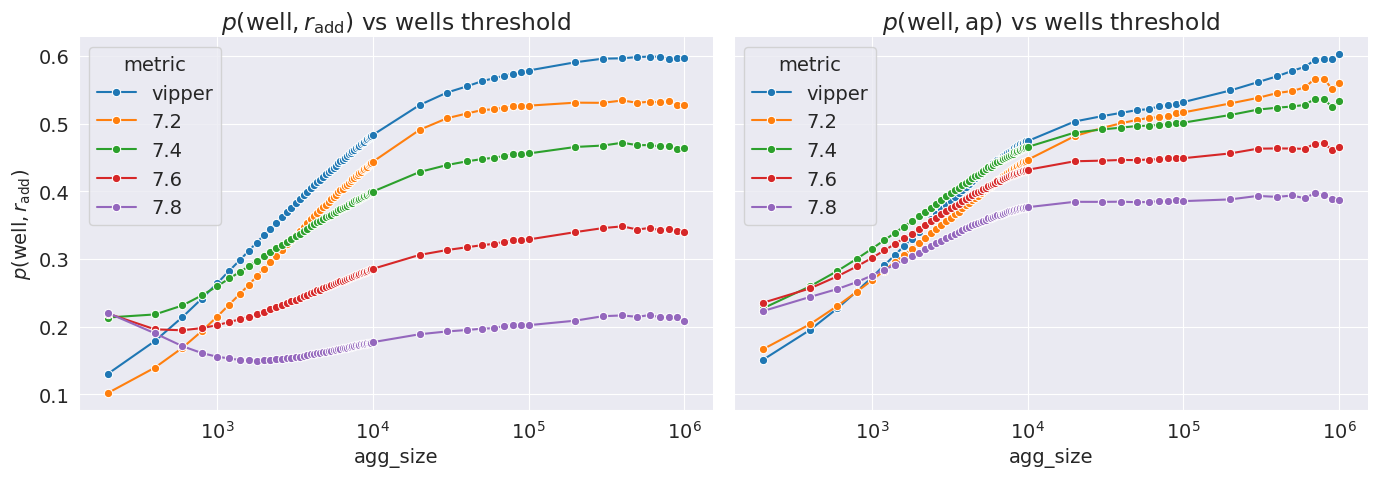

(<Figure size 1400x500 with 2 Axes>,
 (<Axes: title={'center': '$p(\\mathrm{well}, r_{\\mathrm{add}})$ vs wells threshold'}, xlabel='agg_size', ylabel='$p(\\mathrm{well}, r_{\\mathrm{add}})$'>,
  <Axes: title={'center': '$p(\\mathrm{well}, \\mathrm{ap})$ vs wells threshold'}, xlabel='agg_size', ylabel='$p(\\mathrm{well}, \\mathrm{ap})$'>))

In [25]:
plot_scatterplot(
    correlations_evolution_wells,
    x="well vs radd",
    y="well vs ap",
    output_name="experimental/supplementary/correlations_evolution_wells_scatter.svg",
)
#plot_heatmaps(
#    correlations_evolution_wells,
#    value1="well vs radd",
#    value2="well vs ap",
#   output_name="experimental/supplementary/correlations_evolution_wells_heatmap.svg",
#)
plot_lineplots(
    correlations_evolution_wells,
    x="agg_size",
    y1="well vs radd",
    y2="well vs ap",
    x_label="agg_size",
    hue_label="metric",
    hue="metric",
    output_name="experimental/supplementary/correlations_evolution_wells_line.svg",
)

### Correct for GC content

Figure saved to /home/ben/projects/vIP/paper/outputs/experimental/supplementary/correlations_corrected_evolution_wells_scatter.svg


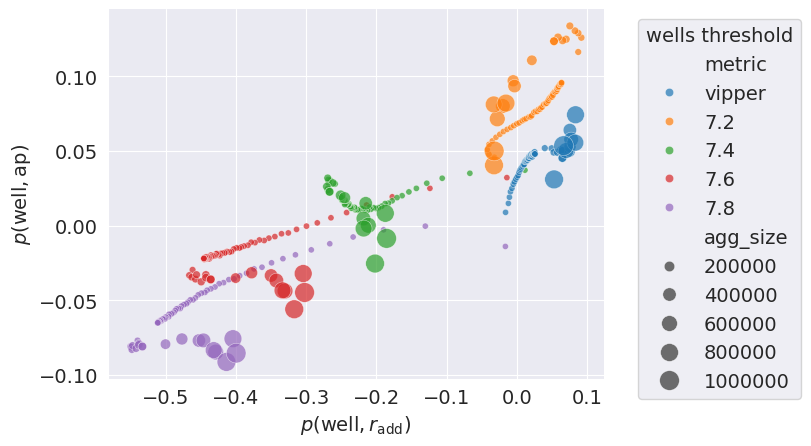

Figure saved to /home/ben/projects/vIP/paper/outputs/experimental/supplementary/correlations_corrected_evolution_wells_line.svg


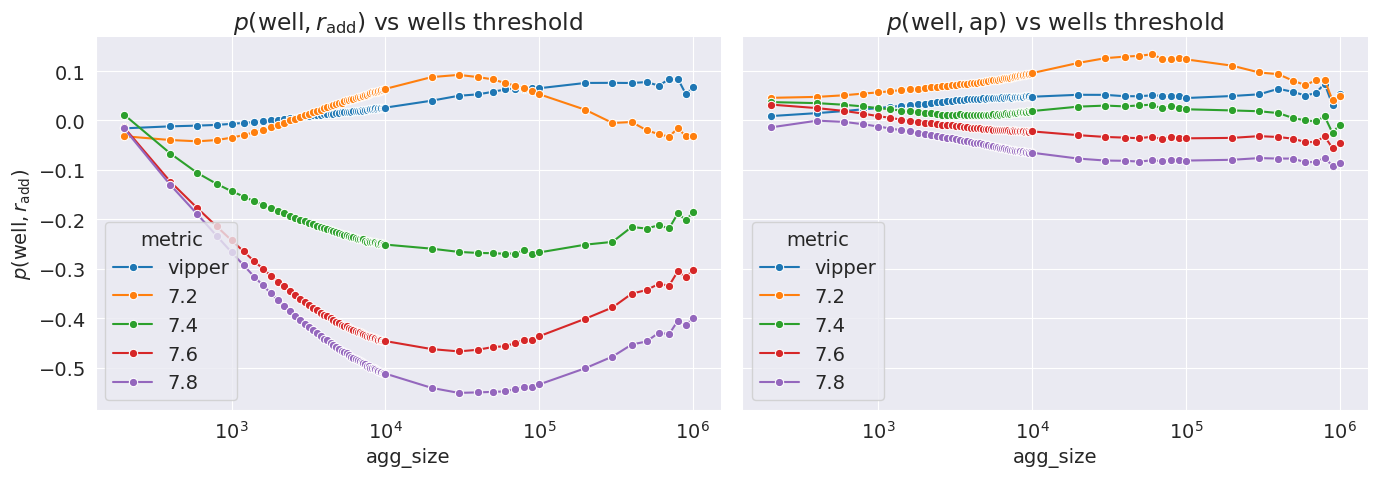

(<Figure size 1400x500 with 2 Axes>,
 (<Axes: title={'center': '$p(\\mathrm{well}, r_{\\mathrm{add}})$ vs wells threshold'}, xlabel='agg_size', ylabel='$p(\\mathrm{well}, r_{\\mathrm{add}})$'>,
  <Axes: title={'center': '$p(\\mathrm{well}, \\mathrm{ap})$ vs wells threshold'}, xlabel='agg_size', ylabel='$p(\\mathrm{well}, \\mathrm{ap})$'>))

In [26]:
correlations_evolution_wells_corrected = correlations_evolution_wells.with_columns(
    (pl.col("well vs radd") - pl.col("well vs GC") * pl.col("GC vs radd")).alias(
        "radd_numerator"
    ),
    (np.sqrt((1 - pl.col("well vs GC") ** 2) * (1 - pl.col("GC vs radd") ** 2))).alias(
        "radd_denominator"
    ),
    (pl.col("well vs ap") - pl.col("well vs GC") * pl.col("GC vs ap")).alias(
        "ap_numerator"
    ),
    (np.sqrt((1 - pl.col("well vs GC") ** 2) * (1 - pl.col("GC vs ap") ** 2))).alias(
        "ap_denominator"
    ),
).with_columns(
    (pl.col("radd_numerator") / pl.col("radd_denominator")).alias(
        "well vs radd corrected"
    ),
    (pl.col("ap_numerator") / pl.col("ap_denominator")).alias("well vs ap corrected"),
)

plot_scatterplot(
    correlations_evolution_wells_corrected,
    x="well vs radd corrected",
    y="well vs ap corrected",
    output_name="experimental/supplementary/correlations_corrected_evolution_wells_scatter.svg",
)
#plot_heatmaps(
#    correlations_evolution_wells_corrected,
#    value1="well vs radd corrected",
#    value2="well vs ap corrected",
#    output_name="experimental/supplementary/correlations_corrected_evolution_wells_heatmap.svg",
#)
plot_lineplots(
    correlations_evolution_wells_corrected,
    x="agg_size",
    y1="well vs radd corrected",
    y2="well vs ap corrected",
    x_label="agg_size",
    hue_label="metric",
    hue="metric",
    output_name="experimental/supplementary/correlations_corrected_evolution_wells_line.svg",
)